In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

normal_dataset = pd.read_excel('../models/normal.xlsx')
normal_dataset.head()

,Time,Intensity,Current
0,2022-02-03 12:31:51.362,0.000006,8.823505e-08
1,2022-02-03 12:31:51.483,0.000005,7.965741e-08
2,2022-02-03 12:31:51.604,0.000004,7.477838e-08
3,2022-02-03 12:31:51.724,0.000004,7.298894e-08
4,2022-02-03 12:31:51.858,0.000003,7.227497e-08


In [2]:
anomaly_dataset = pd.read_excel('../models/anomaly.xlsx')
anomaly_dataset.head()

,Time,Intensity,Current
0,2022-02-04 10:57:33.695,0.000004,7.310214e-08
1,2022-02-04 10:57:33.816,0.000007,1.146507e-07
2,2022-02-04 10:57:33.936,0.000008,1.010314e-07
3,2022-02-04 10:57:34.056,0.000007,1.019369e-07
4,2022-02-04 10:57:34.177,0.000006,8.269153e-08


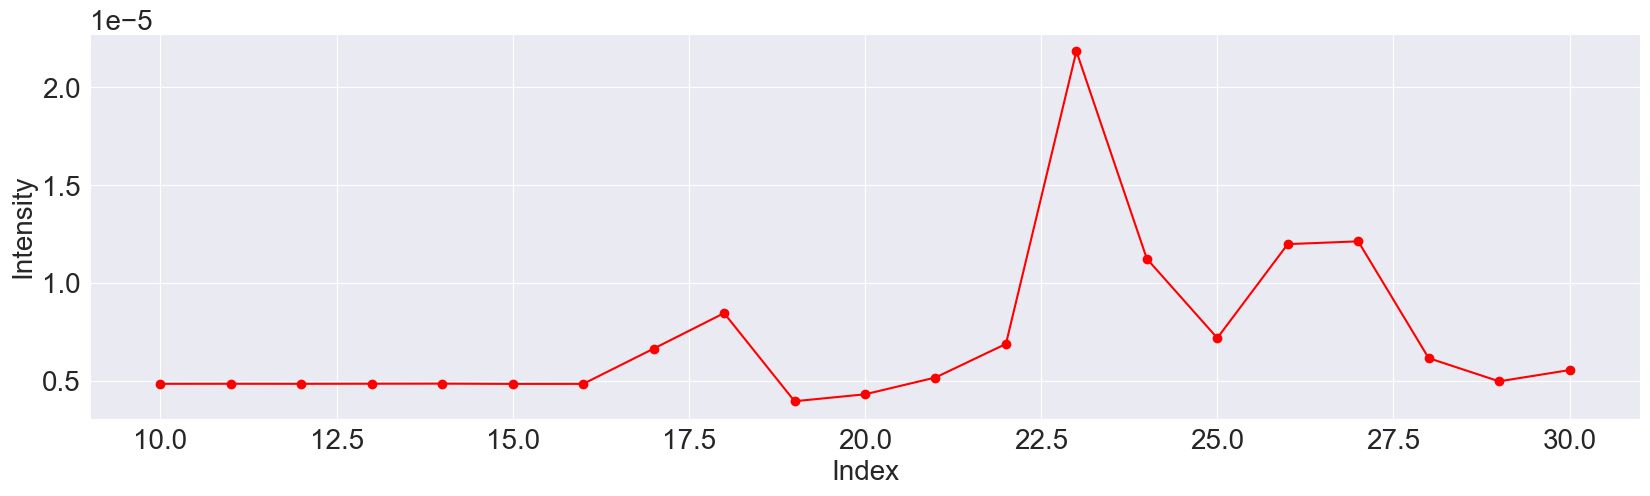

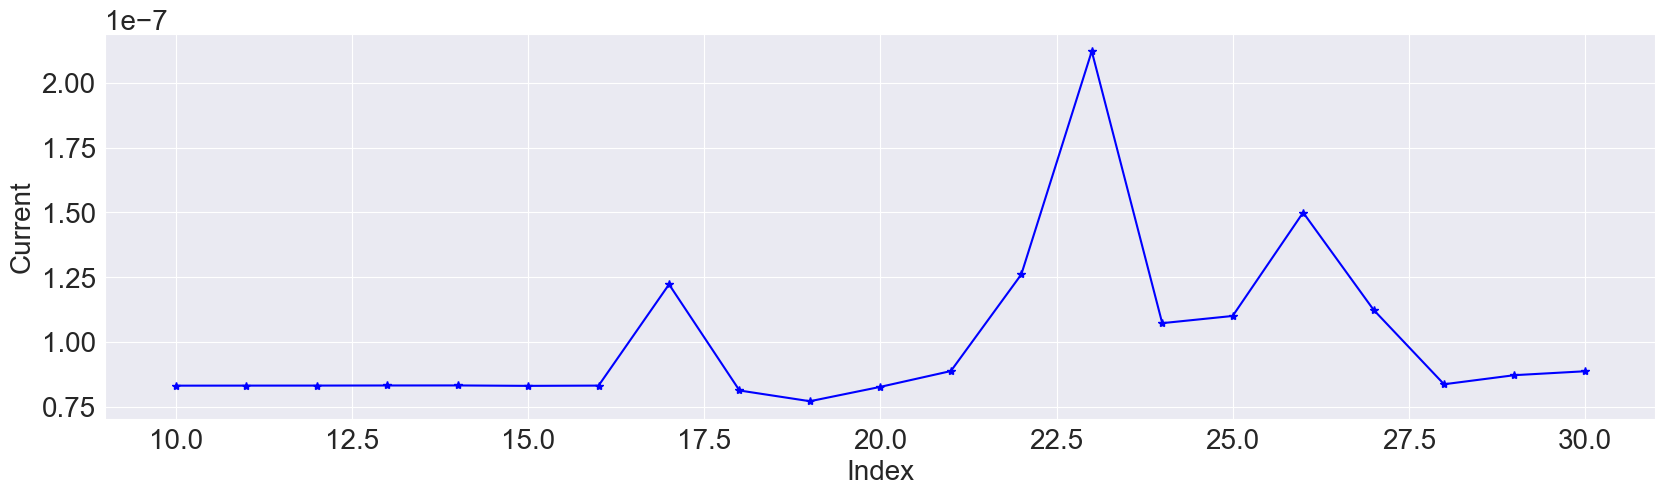

In [3]:
plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

plt.figure(figsize=(20, 5))
plt.xlabel('Index')
plt.ylabel('Intensity')
plt.plot(normal_dataset['Intensity'][10:31], marker='o', color='red')
plt.show()

plt.figure(figsize=(20, 5))
plt.xlabel('Index')
plt.ylabel('Current')
plt.plot(normal_dataset['Current'][10:31], marker='*', color='blue')
plt.show()

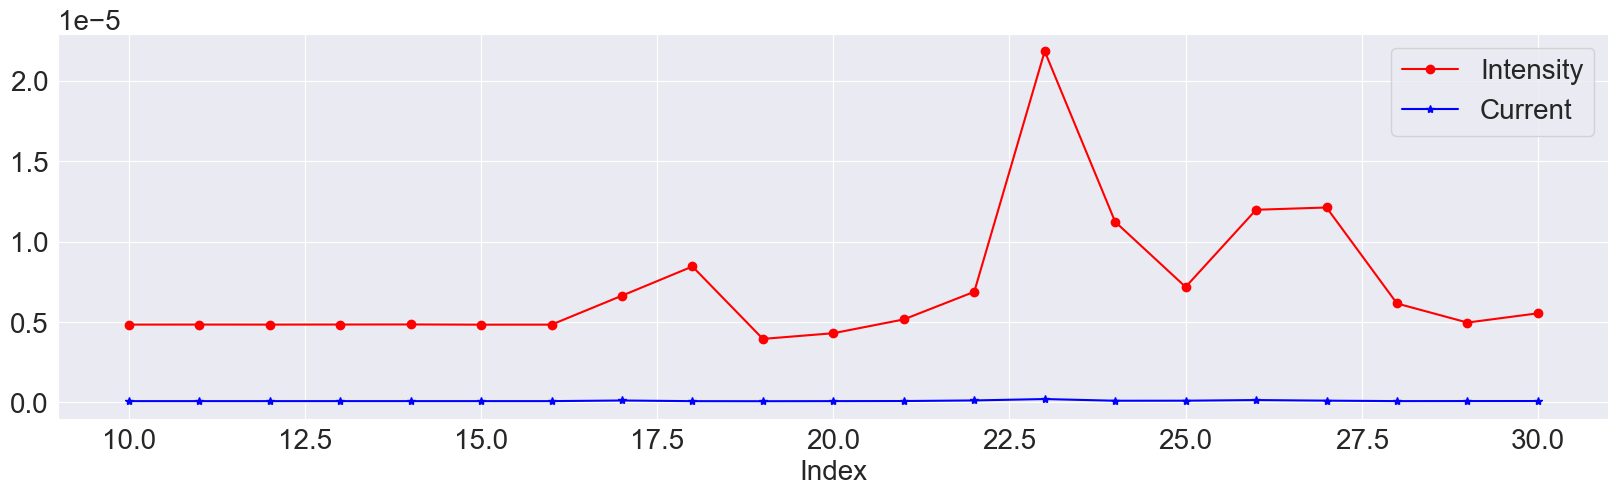

In [4]:
plt.figure(figsize=(20, 5))
plt.xlabel('Index')
plt.plot(normal_dataset['Intensity'][10:31], marker='o', color='red', label='Intensity')
plt.plot(normal_dataset['Current'][10:31], marker='*', color='blue', label='Current')
plt.legend()
plt.show()

In [5]:
normal_dataset.info()
normal_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92280 entries, 0 to 92279
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Time       92280 non-null  datetime64[ns]
 1   Intensity  92280 non-null  float64       
 2   Current    92280 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.1 MB


,Intensity,Current
count,92280.000000,9.228000e+04
mean,0.000008,1.077486e-07
std,0.000002,1.528537e-08
min,0.000003,6.770911e-08
25%,0.000007,9.875811e-08
50%,0.000008,1.057979e-07
75%,0.000009,1.150034e-07
max,0.000023,2.187926e-07


In [6]:
anomaly_dataset.info()
anomaly_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11800 entries, 0 to 11799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Time       11800 non-null  datetime64[ns]
 1   Intensity  11800 non-null  float64       
 2   Current    11800 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 276.7 KB


,Intensity,Current
count,11800.000000,1.180000e+04
mean,0.000006,9.254894e-08
std,0.000002,1.536687e-08
min,0.000003,6.737993e-08
25%,0.000005,8.417759e-08
50%,0.000006,8.969072e-08
75%,0.000007,9.680188e-08
max,0.000043,3.414614e-07


In [7]:
normal_dataset.corr()

,Intensity,Current
Intensity,1.000000,0.835255
Current,0.835255,1.000000


In [8]:
anomaly_dataset.corr()

,Intensity,Current
Intensity,1.000000,0.717665
Current,0.717665,1.000000


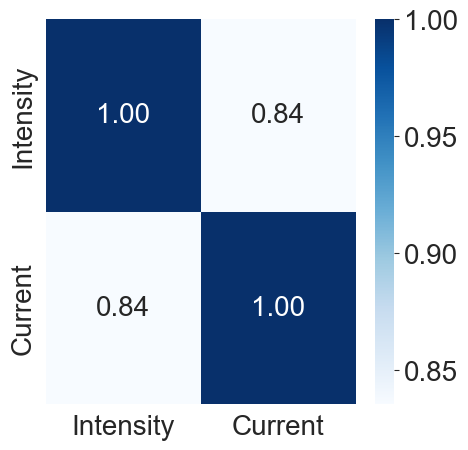

In [9]:
plt.figure(figsize=(5,5))
sns.heatmap(data=normal_dataset.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.show()

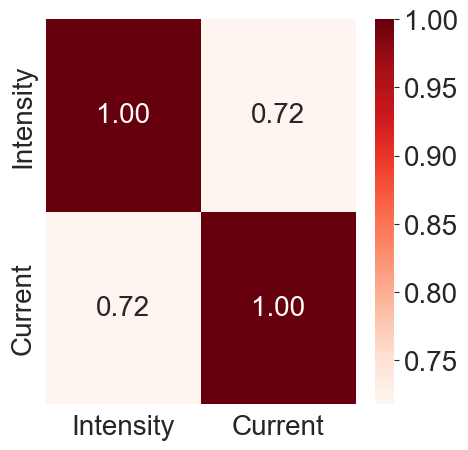

In [10]:
plt.figure(figsize=(5,5))
sns.heatmap(data=anomaly_dataset.corr(), annot=True, fmt='.2f', cmap='Reds')
plt.show()

In [11]:
train_dataset = normal_dataset['Intensity'][:80480].values
test_dataset = pd.concat([normal_dataset['Intensity'][80480:], anomaly_dataset['Intensity']],
ignore_index=True).values
print('학습데이터 수:', len(train_dataset))
print('평가데이터 수:', len(test_dataset))

학습데이터 수: 80480
평가데이터 수: 23600


In [12]:
type(train_dataset)
type(test_dataset)
train_dataset.shape
test_dataset.shape


(23600,)

In [13]:
scaler = StandardScaler()
train_dataset = scaler.fit_transform(train_dataset.reshape(-1, 1))
test_dataset = scaler.transform(test_dataset.reshape(-1, 1))

In [14]:
train_dataset.shape
test_dataset.shape

(23600, 1)

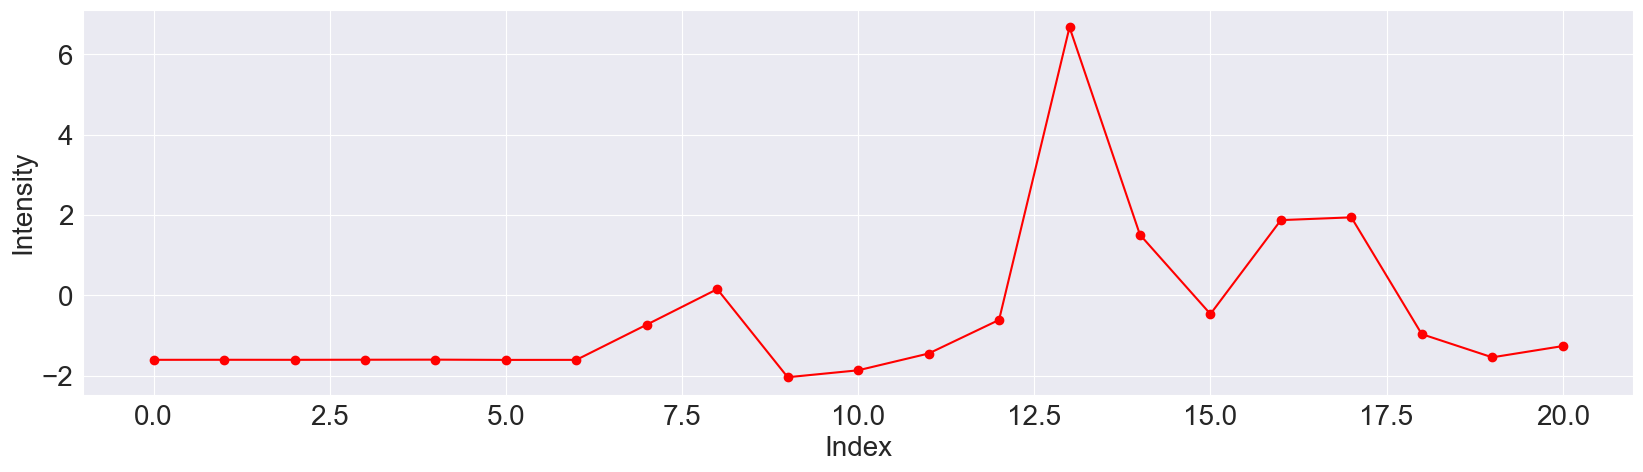

In [15]:
plt.figure(figsize=(20, 5))
plt.xlabel('Index')
plt.ylabel('Intensity')
plt.plot(train_dataset[10:31], marker='o', color='red')
plt.show()

In [16]:
time_step = 40
train_dataset = train_dataset.reshape(-1, time_step, 1)
test_dataset = test_dataset.reshape(-1, time_step, 1)
print('학습데이터 Shape:', train_dataset.shape)
print('평가데이터 Shape:', test_dataset.shape)

학습데이터 Shape: (2012, 40, 1)
평가데이터 Shape: (590, 40, 1)


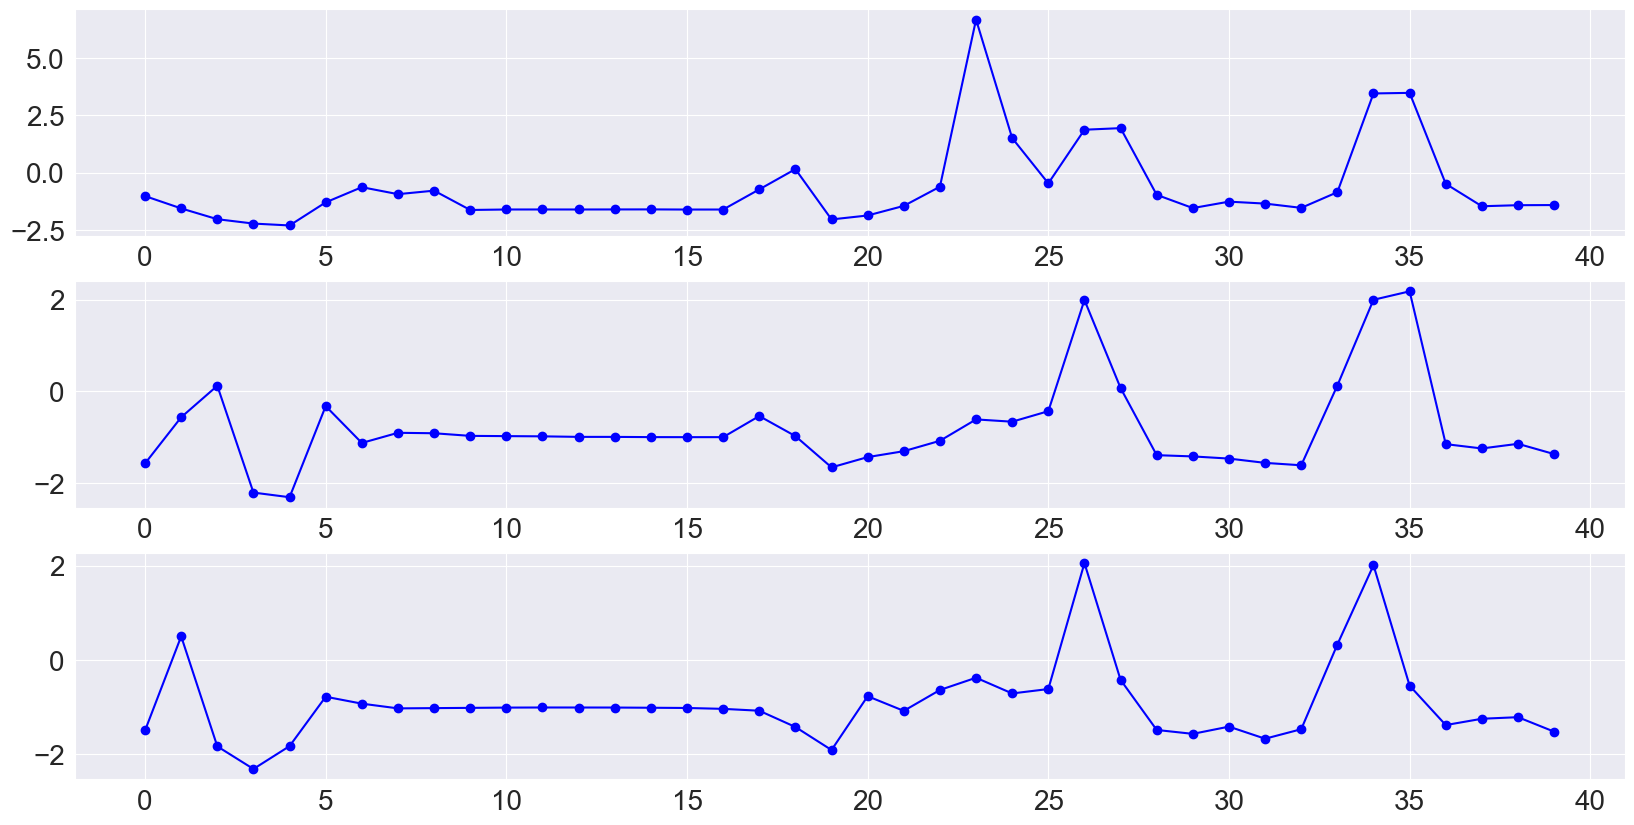

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
plt.plot(train_dataset[0], marker='o', color='blue')
plt.subplot(3, 1, 2)
plt.plot(train_dataset[1], marker='o', color='blue')
plt.subplot(3, 1, 3)
plt.plot(train_dataset[2], marker='o', color='blue')
plt.show()

In [18]:
model = Sequential()
model.add(LSTM(units=250, activation='tanh', input_shape=(time_step, 1)))
model.add(RepeatVector(n=time_step))
model.add(LSTM(units=250, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(units=1)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               252000    
                                                                 
 repeat_vector (RepeatVecto  (None, 40, 250)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 40, 250)           501000    
                                                                 
 time_distributed (TimeDist  (None, 40, 1)             251       
 ributed)                                                        
                                                                 
Total params: 753251 (2.87 MB)
Trainable params: 753251 (2.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(loss='mae', optimizer='adam')
history = model.fit(x=train_dataset, y=train_dataset,
epochs=200, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

Epoch 1/200
51/51 [==============================] - 5s 63ms/step - loss: 0.6152 - val_loss: 0.6048
Epoch 2/200
51/51 [==============================] - 3s 54ms/step - loss: 0.5943 - val_loss: 0.6013
Epoch 3/200
51/51 [==============================] - 3s 54ms/step - loss: 0.5833 - val_loss: 0.5911
Epoch 4/200
51/51 [==============================] - 3s 55ms/step - loss: 0.5796 - val_loss: 0.5908
Epoch 5/200
51/51 [==============================] - 3s 55ms/step - loss: 0.5710 - val_loss: 0.5749
Epoch 6/200
51/51 [==============================] - 3s 53ms/step - loss: 0.5610 - val_loss: 0.5647
Epoch 7/200
51/51 [==============================] - 3s 51ms/step - loss: 0.5511 - val_loss: 0.5573
Epoch 8/200
51/51 [==============================] - 3s 53ms/step - loss: 0.5472 - val_loss: 0.5531
Epoch 9/200
51/51 [==============================] - 3s 51ms/step - loss: 0.5351 - val_loss: 0.5454
Epoch 10/200
51/51 [==============================] - 3s 50ms/step - loss: 0.5384 - val_loss: 0.5423

In [20]:
history.history['loss']

[0.6152463555335999,
 0.5943391919136047,
 0.5832860469818115,
 0.5796210169792175,
 0.5710152387619019,
 0.5609648823738098,
 0.5510668158531189,
 0.5471524596214294,
 0.5350841283798218,
 0.5383832454681396,
 0.5285784602165222,
 0.5190141797065735,
 0.5065280199050903,
 0.5056015253067017,
 0.493211030960083,
 0.48211386799812317,
 0.4750297963619232,
 0.4580424726009369,
 0.45458680391311646,
 0.4316534698009491,
 0.4235089421272278,
 0.38583505153656006,
 0.37481924891471863,
 0.3628755509853363,
 0.3467564582824707,
 0.34114035964012146,
 0.33234652876853943,
 0.30858537554740906,
 0.30400729179382324,
 0.3010416030883789,
 0.28725466132164,
 0.2805861532688141,
 0.28283172845840454,
 0.2867089509963989,
 0.26814496517181396,
 0.2631402909755707,
 0.26666221022605896,
 0.25730371475219727,
 0.2651751935482025,
 0.2521250247955322,
 0.2603932321071625,
 0.2624697685241699,
 0.26464587450027466,
 0.26200276613235474,
 0.2605927884578705,
 0.24711786210536957,
 0.23320631682872772,


In [21]:
history.history['val_loss']

[0.6048234701156616,
 0.6012851595878601,
 0.5910849571228027,
 0.5908278822898865,
 0.5749422907829285,
 0.5647263526916504,
 0.5573058724403381,
 0.5531254410743713,
 0.5454260110855103,
 0.5423154830932617,
 0.5309270620346069,
 0.5239192843437195,
 0.5385071039199829,
 0.5081155896186829,
 0.494527667760849,
 0.5140063762664795,
 0.5005975961685181,
 0.45946386456489563,
 0.42711731791496277,
 0.48046934604644775,
 0.4013111889362335,
 0.4001563787460327,
 0.37878748774528503,
 0.3655552268028259,
 0.3890800476074219,
 0.3398112952709198,
 0.3228432536125183,
 0.3279050290584564,
 0.311426043510437,
 0.3052467405796051,
 0.2949855923652649,
 0.29057005047798157,
 0.2898798882961273,
 0.27563244104385376,
 0.27826038002967834,
 0.27189886569976807,
 0.2810105085372925,
 0.29591459035873413,
 0.2859507203102112,
 0.26155608892440796,
 0.3112223148345947,
 0.304887592792511,
 0.29045793414115906,
 0.2690622806549072,
 0.2895212471485138,
 0.26287344098091125,
 0.25211766362190247,
 0.

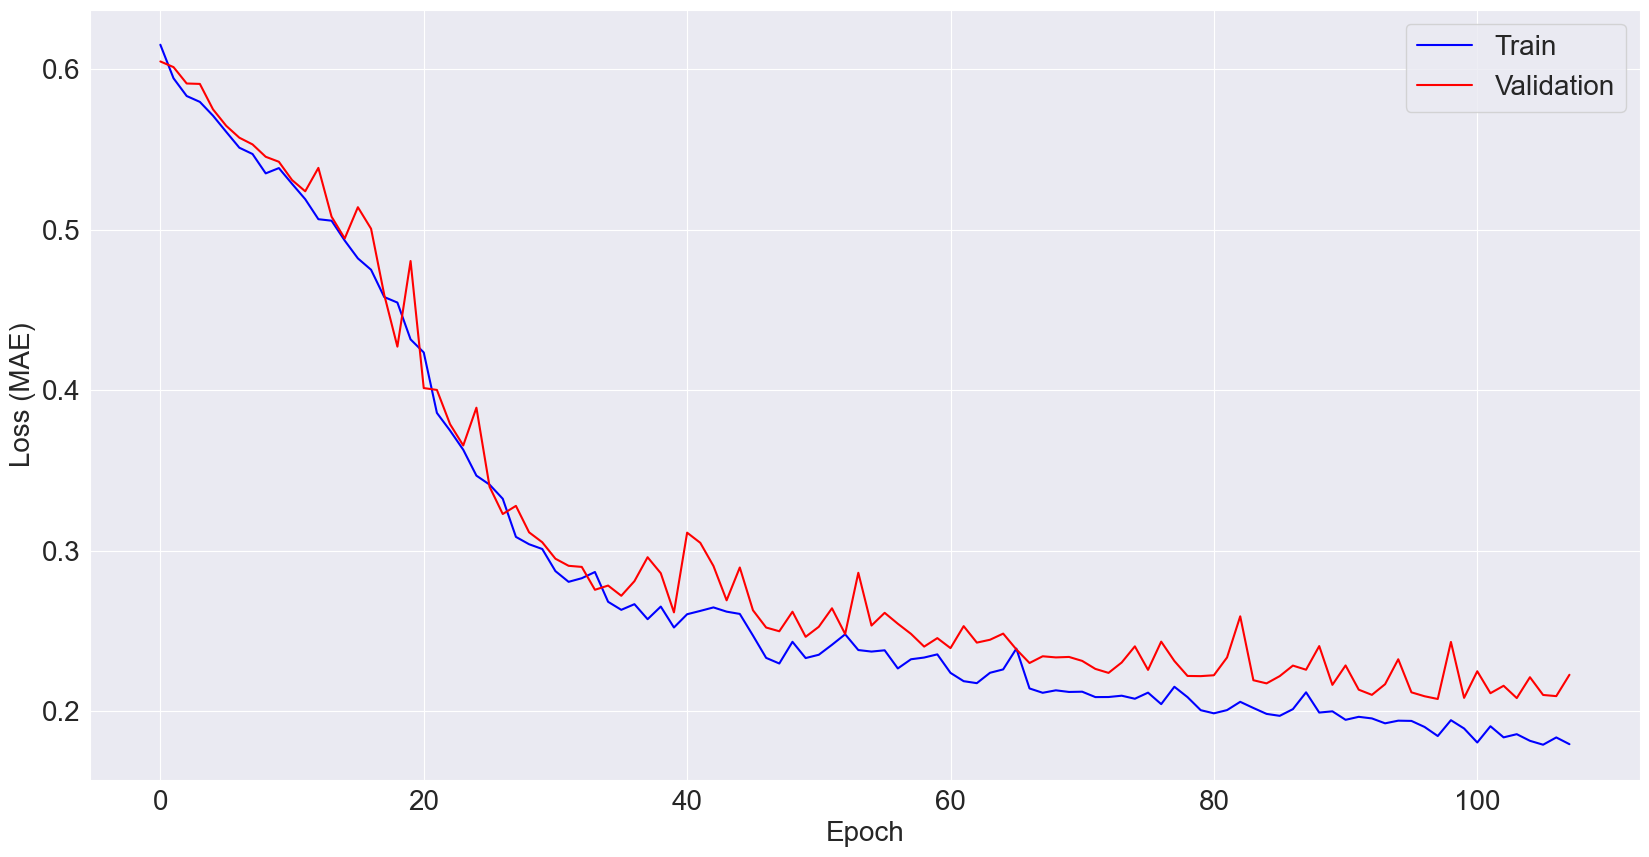

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], color='blue', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Validation')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [23]:
train_yhat = model.predict(train_dataset)
train_yhat.shape

63/63 [==============================] - 2s 18ms/step


(2012, 40, 1)

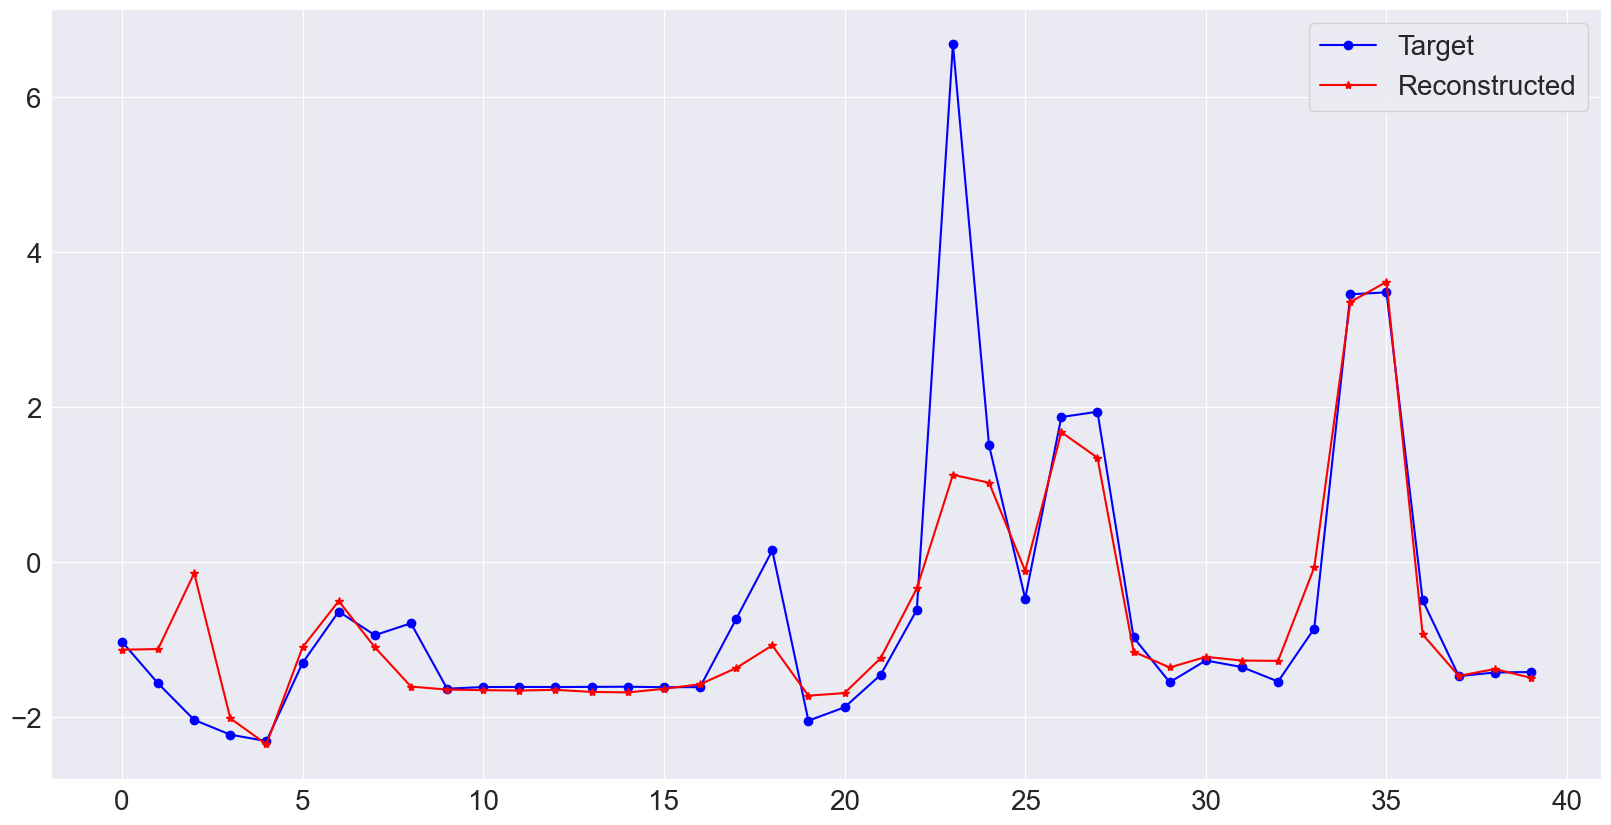

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(train_dataset[0], marker='o', color='blue', label='Target')
plt.plot(train_yhat[0], marker='*', color='red', label='Reconstructed')
plt.legend()
plt.show()

In [25]:
train_mae = np.mean(np.abs(train_yhat - train_dataset), axis=1)
train_mae

array([[0.41780141],
       [0.17604341],
       [0.19322418],
       ...,
       [0.12958206],
       [0.14765518],
       [0.29444482]])

In [26]:
print('복원오차(MAE) - 최솟값:', train_mae.min())
print('복원오차(MAE) - 최댓값:', train_mae.max())

복원오차(MAE) - 최솟값: 0.07490690276843517
복원오차(MAE) - 최댓값: 0.839992006826804


In [27]:
best_mae = np.where(train_mae == train_mae.min())[0][0]
worst_mae = np.where(train_mae == train_mae.max())[0][0]
print('복원오차(MAE) - 최솟값 인덱스:', best_mae)
print('복원오차(MAE) - 최댓값 인덱스:', worst_mae)

복원오차(MAE) - 최솟값 인덱스: 1459
복원오차(MAE) - 최댓값 인덱스: 1838


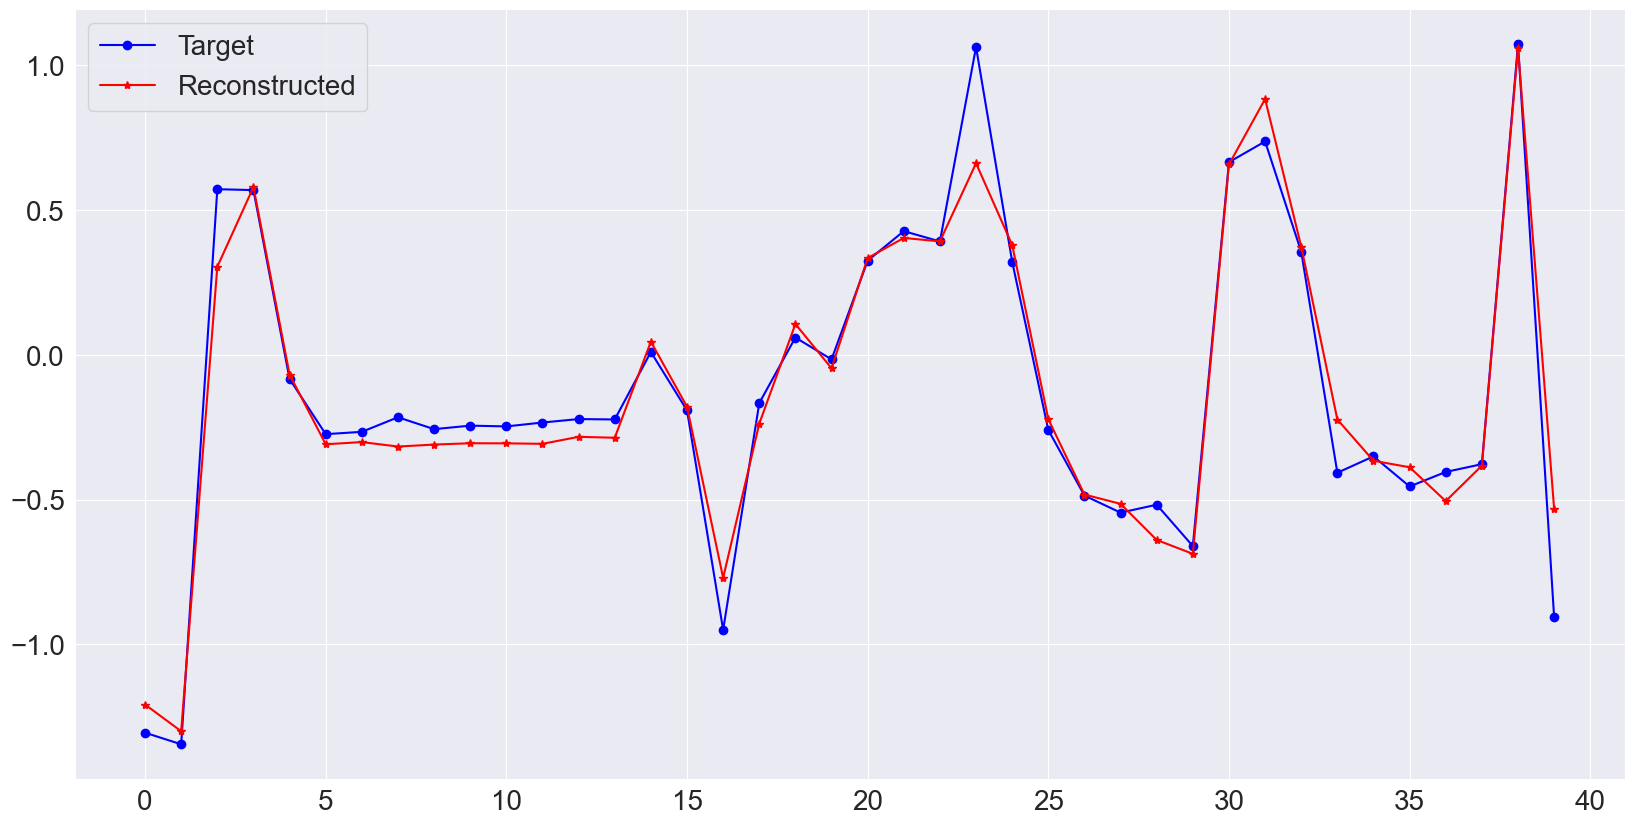

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(train_dataset[best_mae], marker='o', color='blue', label='Target')
plt.plot(train_yhat[best_mae], marker='*', color='red', label='Reconstructed')
plt.legend()
plt.show()

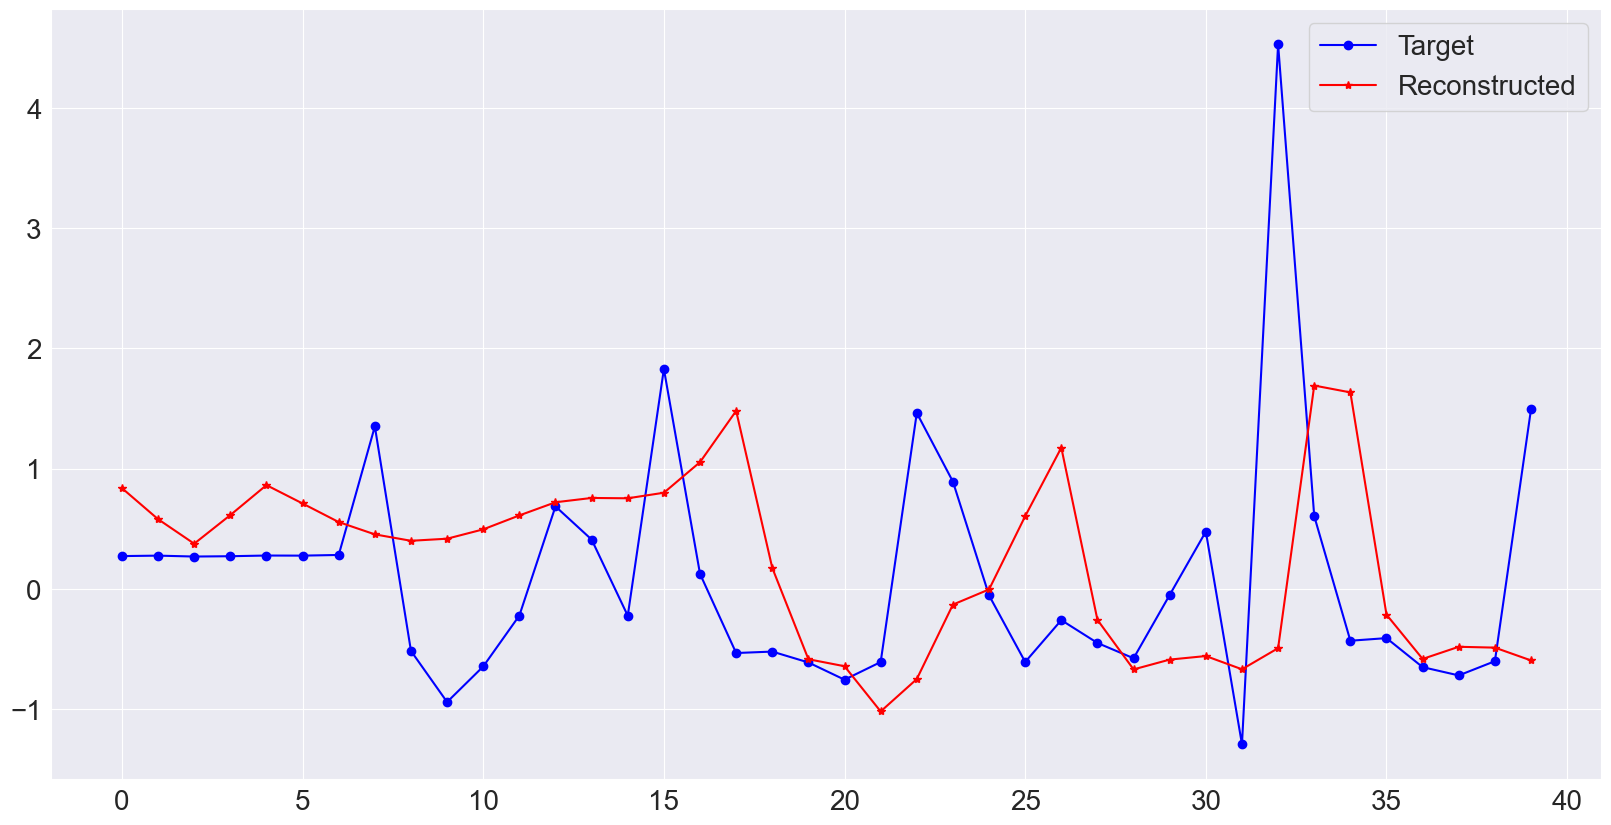

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(train_dataset[worst_mae], marker='o', color='blue', label='Target')
plt.plot(train_yhat[worst_mae], marker='*', color='red', label='Reconstructed')
plt.legend()
plt.show() 

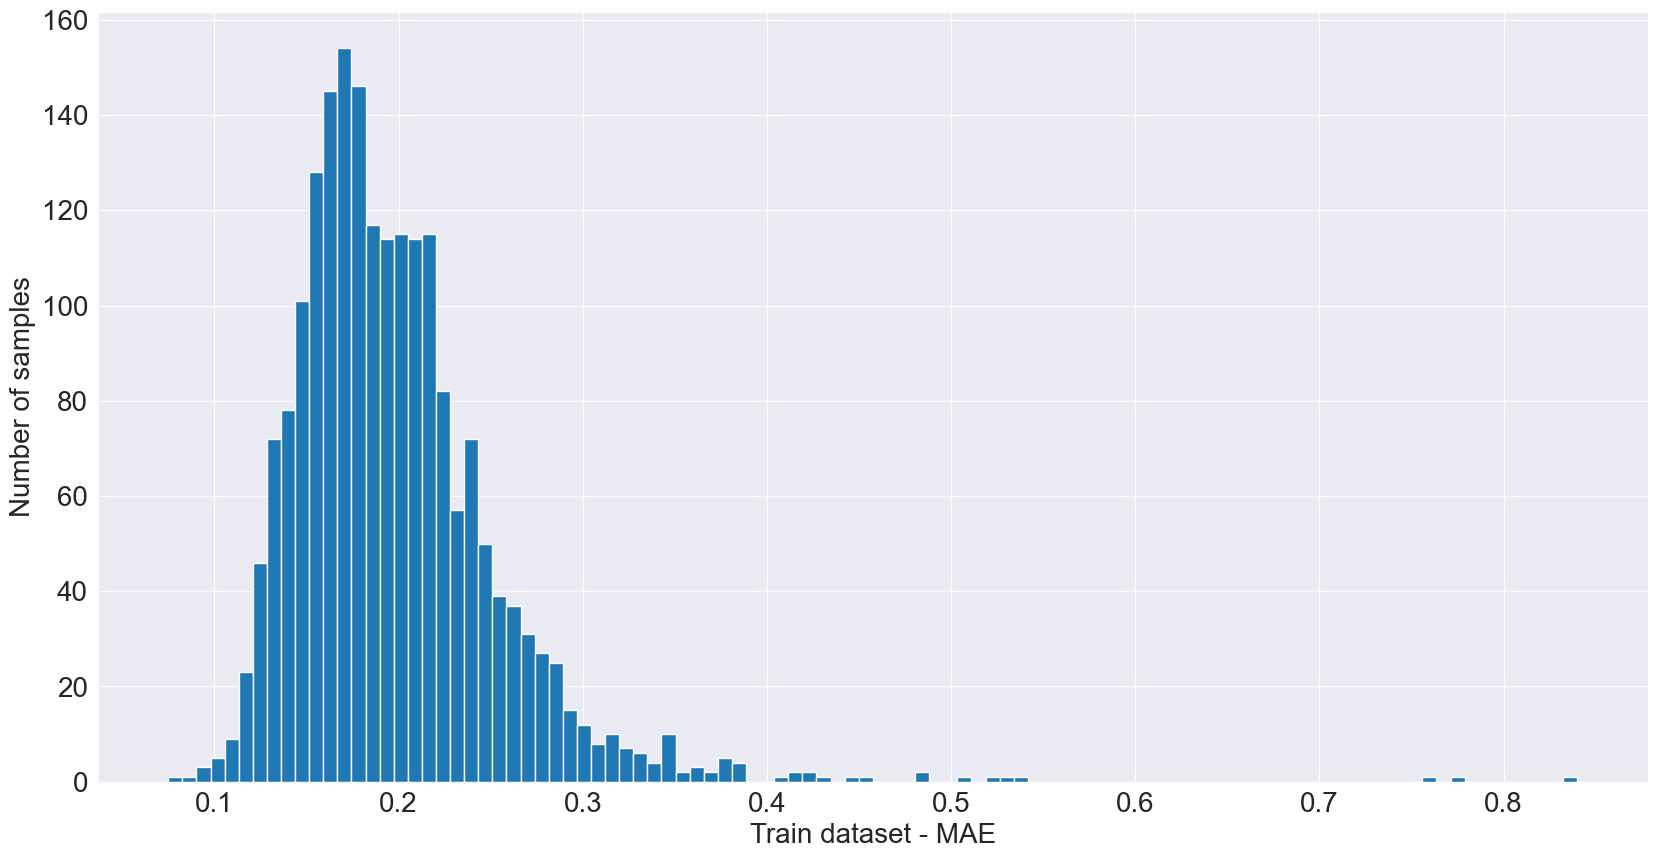

In [30]:
plt.figure(figsize=(20, 10))
plt.hist(x=train_mae, bins=100)
plt.xlabel('Train dataset - MAE')
plt.ylabel('Number of samples')
plt.show()

In [31]:
threshold = np.mean(train_mae) + 3 * np.std(train_mae)
print('임계치 :', threshold)

임계치 : 0.3725171574573708


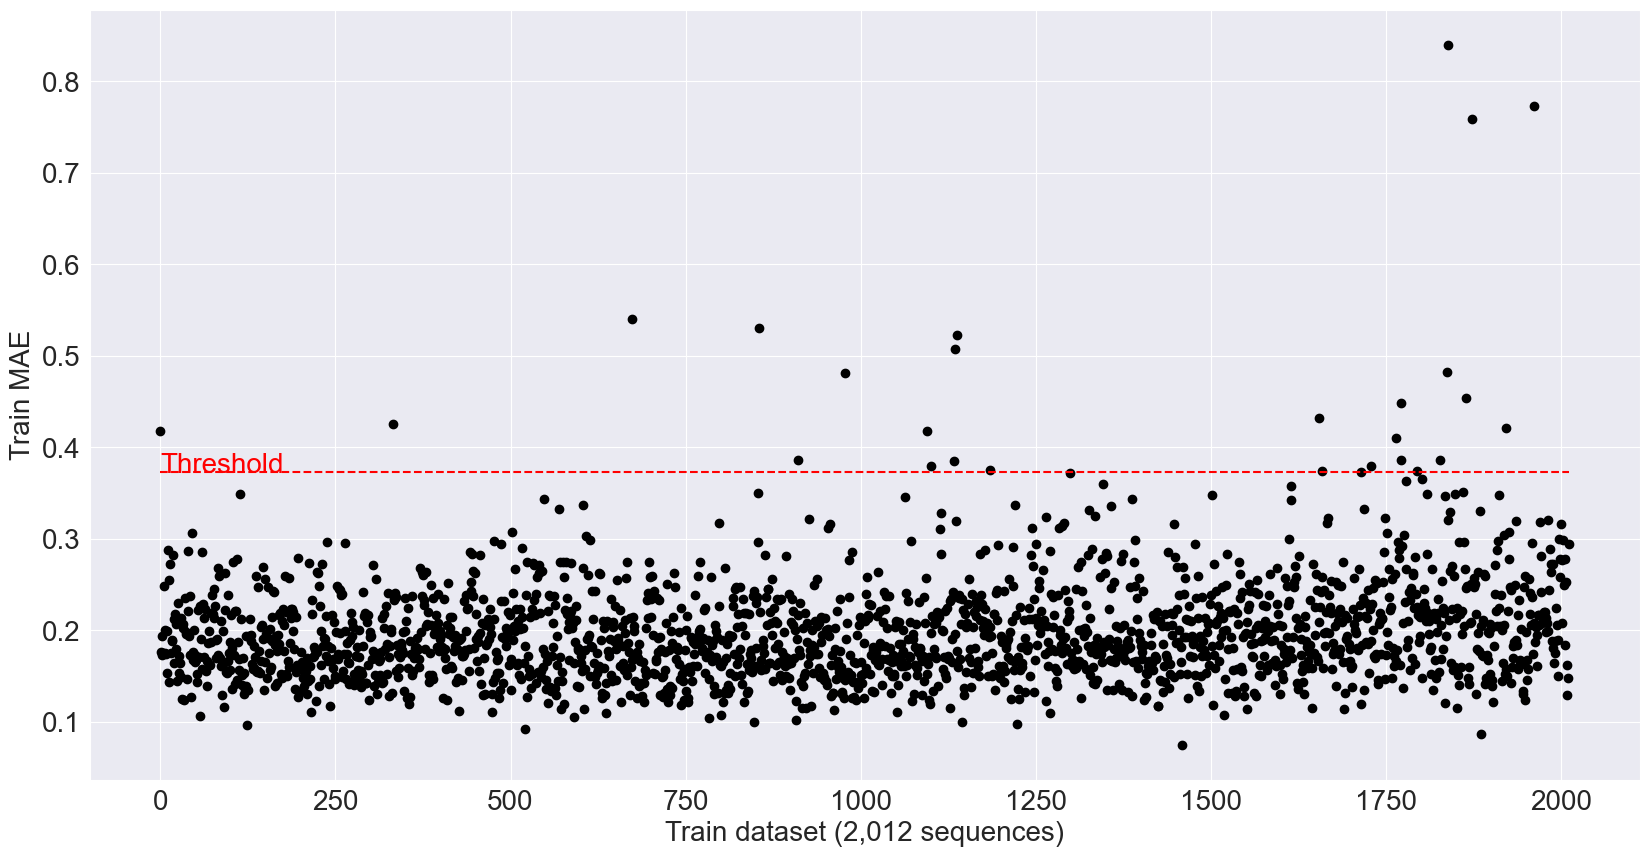

In [32]:
plt.figure(figsize=(20, 10))
plt.text(x=0, y=threshold, s='Threshold', fontsize=20, color='red')
plt.hlines(y=threshold, xmin=0, xmax=len(train_mae), color='red', linestyle='--')
plt.xlabel('Train dataset (2,012 sequences)')
plt.ylabel('Train MAE')
plt.scatter(x=np.arange(0, 2012), y=train_mae, color='black')
plt.show()

19/19 [==============================] - 0s 17ms/step


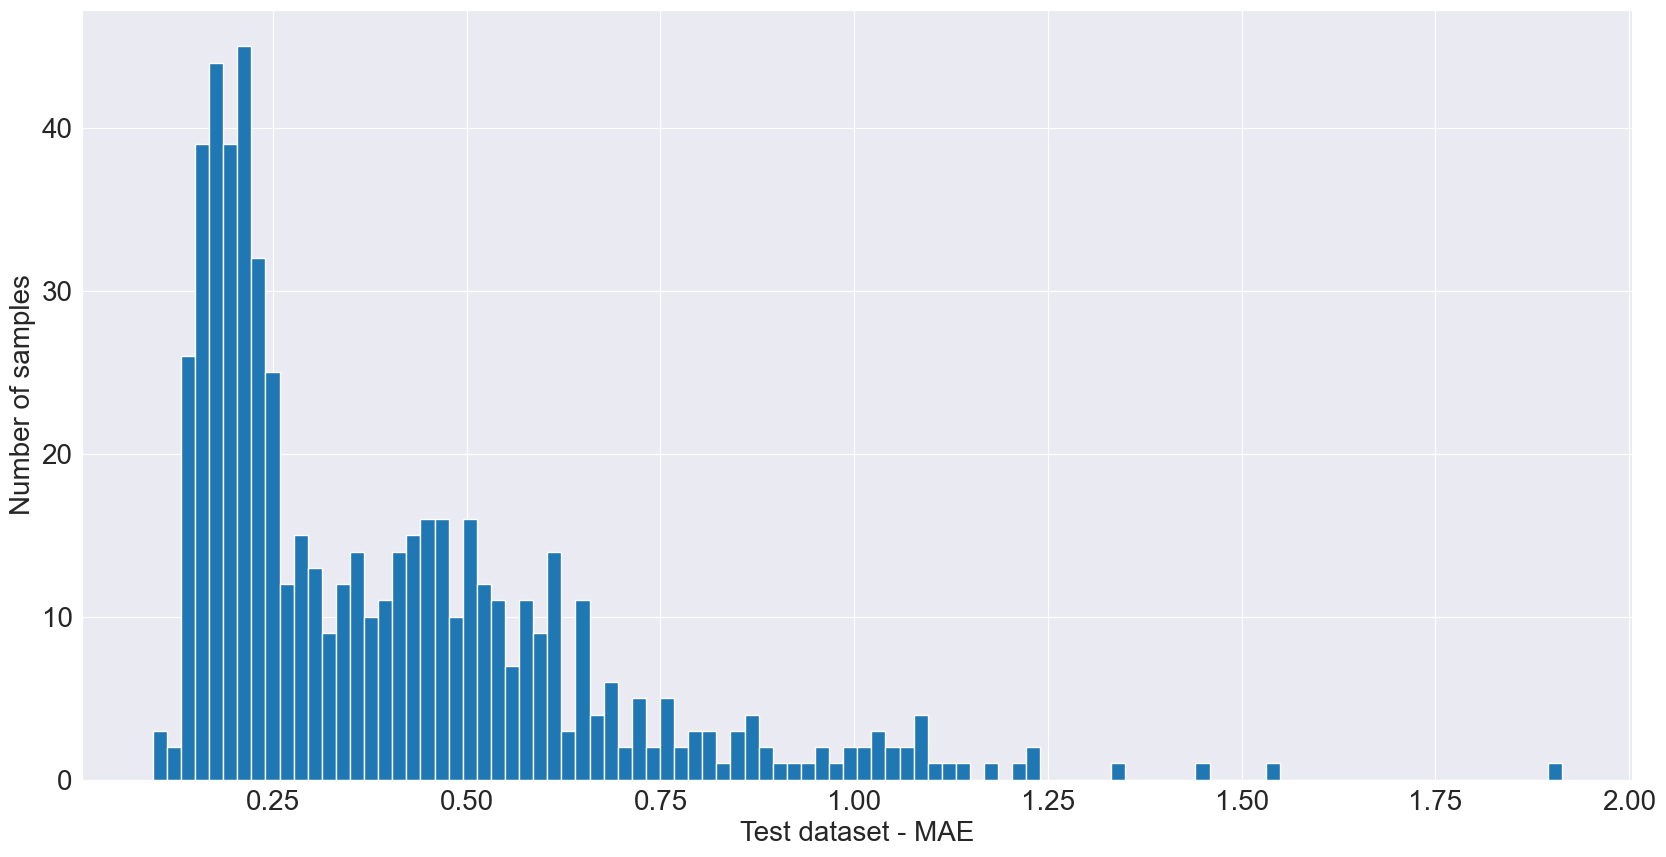

In [33]:
test_yhat = model.predict(test_dataset)
test_mae = np.mean(np.abs(test_yhat - test_dataset), axis=1)
plt.figure(figsize=(20, 10))
plt.hist(x=test_mae, bins=100)
plt.xlabel('Test dataset - MAE')
plt.ylabel('Number of samples')
plt.show()

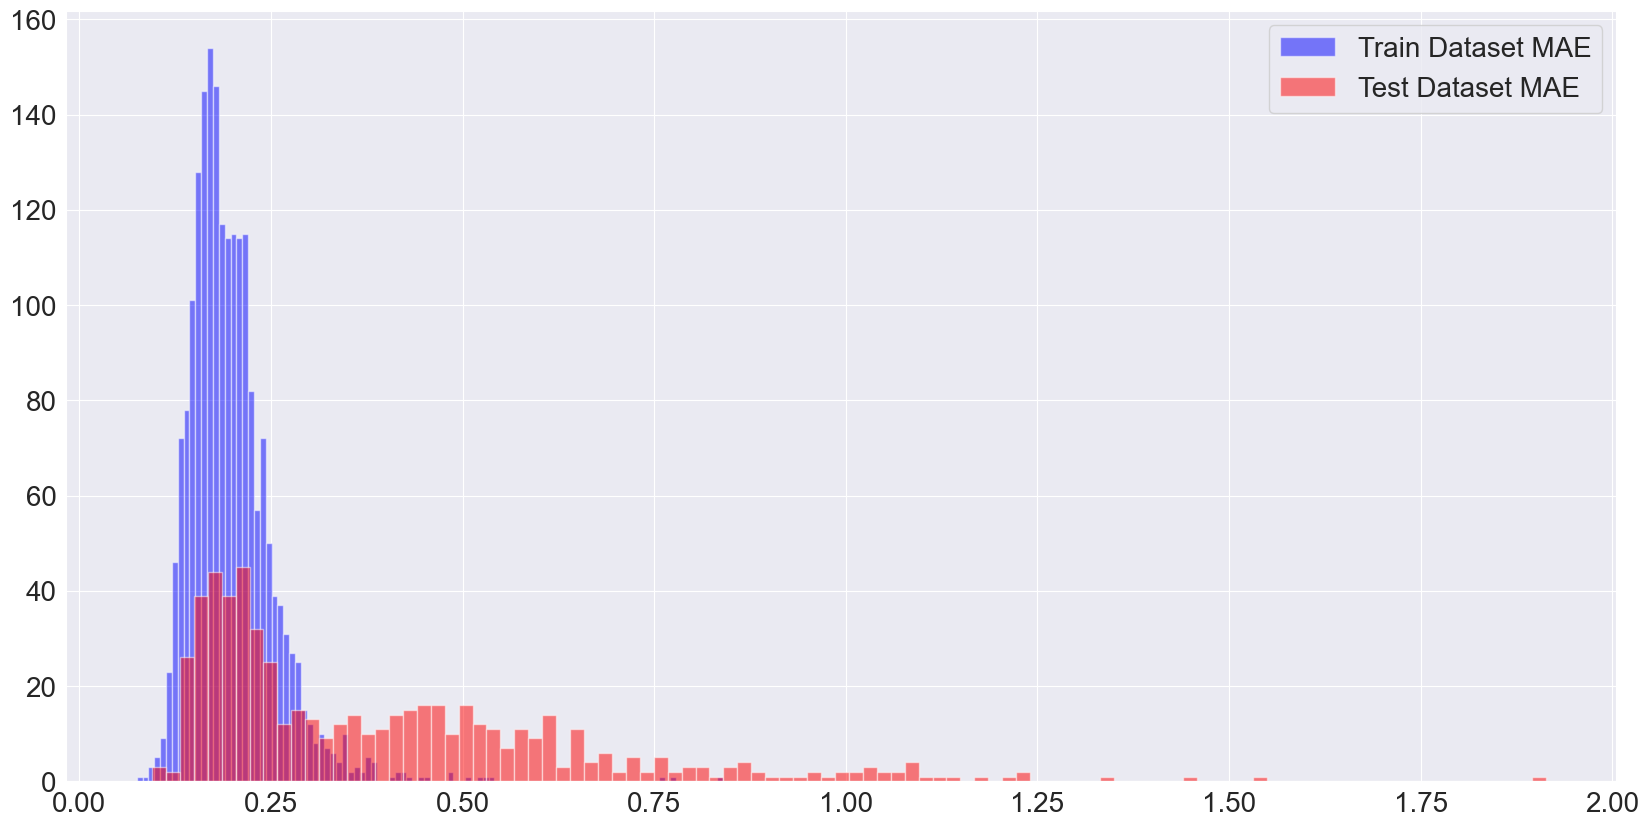

In [34]:
plt.figure(figsize=(20, 10))
plt.hist(x=train_mae, bins=100, color='blue', alpha=0.5, label='Train Dataset MAE')
plt.hist(x=test_mae, bins=100, color='red', alpha=0.5, label='Test Dataset MAE')
plt.legend()
plt.show()

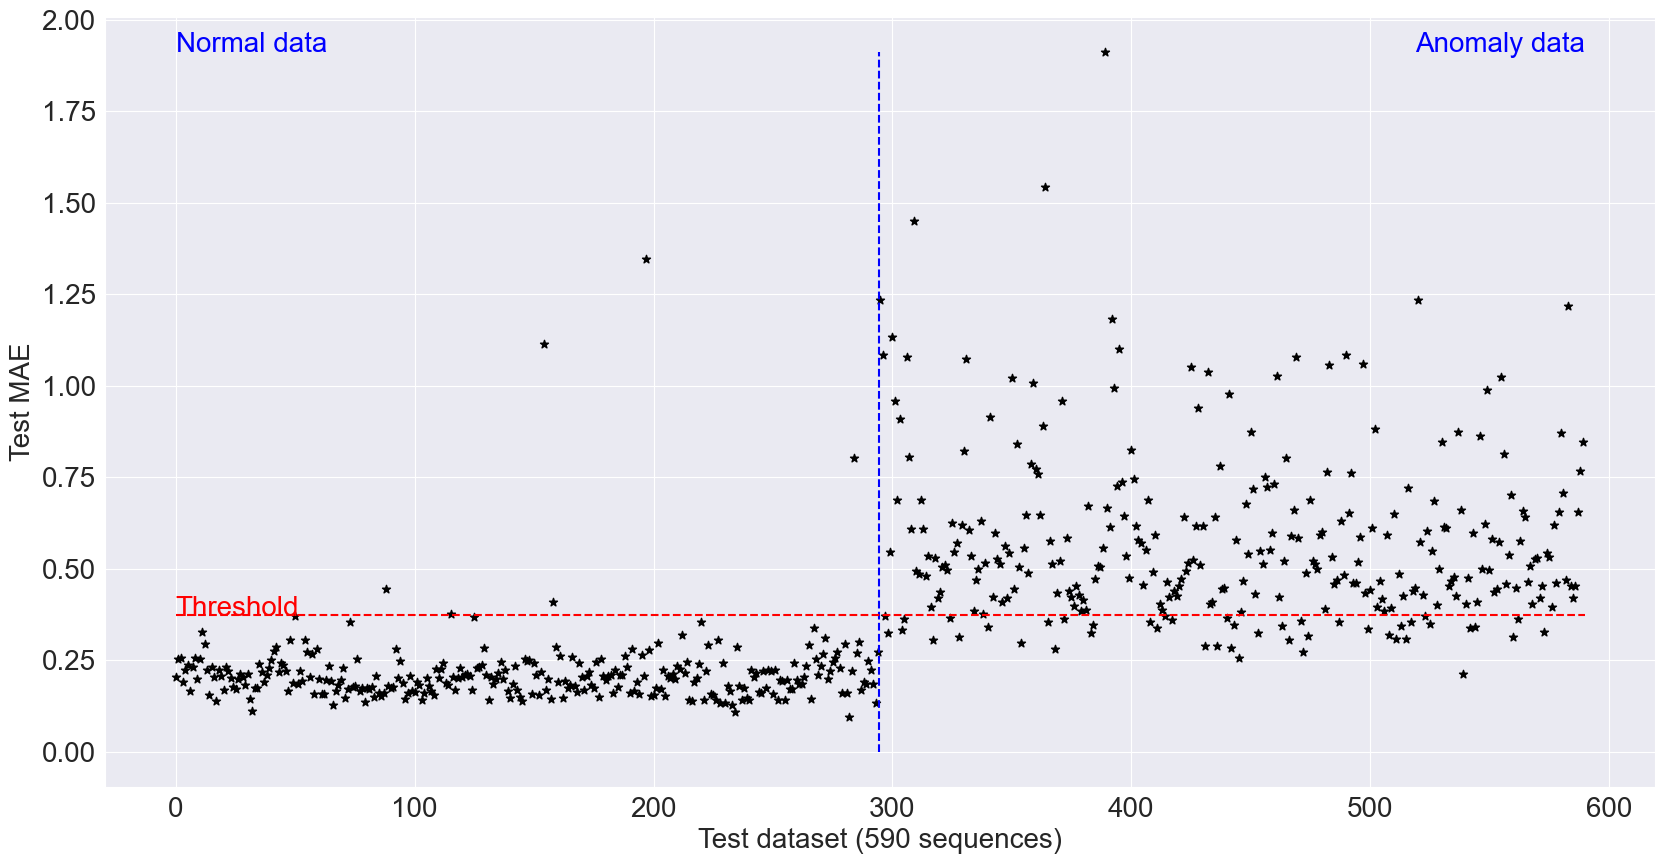

In [35]:
plt.figure(figsize=(20, 10))
plt.text(x=0, y=max(test_mae), s='Normal data', horizontalalignment='left', color='blue')
plt.text(x=len(test_mae), y=max(test_mae), s='Anomaly data', horizontalalignment='right', color='blue')
plt.vlines(x=294.5, ymin=0, ymax=max(test_mae), color='blue', linestyle='--')
plt.text(x=0, y=threshold, s='Threshold', fontsize=20, color='red')
plt.hlines(y=threshold, xmin=0, xmax=len(test_mae), color='red', linestyle='--')
plt.xlabel('Test dataset (590 sequences)')
plt.ylabel('Test MAE')
plt.scatter(x=np.arange(0, 590), y=test_mae, color='black', marker='*')
plt.show()

In [36]:
result = pd.DataFrame(data=test_mae, columns=['MAE'])
result['Target'] = -1
result['Prediction'] = -1
result

,MAE,Target,Prediction
0,0.202826,-1,-1
1,0.252128,-1,-1
2,0.254909,-1,-1
3,0.189666,-1,-1
4,0.223317,-1,-1
...,...,...,...
585,0.418881,-1,-1
586,0.452161,-1,-1
587,0.654984,-1,-1
588,0.765664,-1,-1


In [37]:
Normal = 0
Anomaly = 1
result.loc[:295, 'Target'] = Normal
result.loc[295:, 'Target'] = Anomaly
result

,MAE,Target,Prediction
0,0.202826,0,-1
1,0.252128,0,-1
2,0.254909,0,-1
3,0.189666,0,-1
4,0.223317,0,-1
...,...,...,...
585,0.418881,1,-1
586,0.452161,1,-1
587,0.654984,1,-1
588,0.765664,1,-1


In [38]:
result.loc[result['MAE'] <= threshold, 'Prediction'] = Normal
result.loc[result['MAE'] > threshold, 'Prediction'] = Anomaly
result

,MAE,Target,Prediction
0,0.202826,0,0
1,0.252128,0,0
2,0.254909,0,0
3,0.189666,0,0
4,0.223317,0,0
...,...,...,...
585,0.418881,1,1
586,0.452161,1,1
587,0.654984,1,1
588,0.765664,1,1


In [39]:
cm = confusion_matrix(result['Target'], result['Prediction'])
print('혼동행렬(Confusion Matrix) \n', cm)

혼동행렬(Confusion Matrix) 
 [[289   6]
 [ 45 250]]


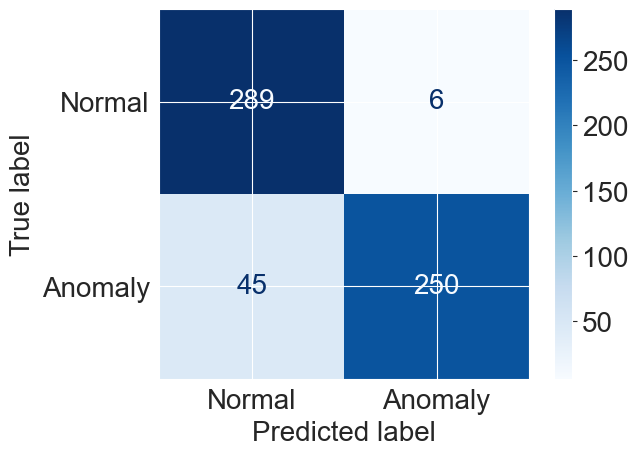

In [40]:
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Normal', 'Anomaly'])
display.plot(cmap = plt.cm.Blues)
plt.show()

In [41]:
print(classification_report(result['Target'], result['Prediction'], target_names=['Normal', 'Anomaly']))

              precision    recall  f1-score   support

      Normal       0.87      0.98      0.92       295
     Anomaly       0.98      0.85      0.91       295

    accuracy                           0.91       590
   macro avg       0.92      0.91      0.91       590
weighted avg       0.92      0.91      0.91       590
